## Méthode de tir pour résoudre le système d’optimalité (Eq. 10), en dimension 2

**But.** Pour $A\in\mathcal{M}_{2}(\mathbb{R})$, $G_2\in\mathcal{M}_{2}(\mathbb{R})$, $C\in\mathcal{M}_{2}(\mathbb{R})$, et $q_1,q_2>0$ des pondérations, construire le couple optimal
\begin{aligned}
h^\star(t) &= -\tfrac{1}{q_2} G_2^\top p(t),\\
z(0) &= -\tfrac{1}{q_1} p(0)
\end{aligned}
où $(z,p)$ est solution du système d’optimalité donné par le TPBVP:
\begin{aligned}
z'(t) &= A z(t) + G h^\star(t) = A z(t) - \tfrac{1}{q_2} G G^\top p(t), \quad z(0) = -\tfrac{1}{q_1} s,\\
p'(t) &= -A^\top p(t) - C^\top\!\big(C z(t) - y^{\mathrm m}(t)\big), \quad p(T)=0,
\end{aligned}
et $s := p(0)\in\mathbb{R}^n$ est **l’inconnue de tir**. 

---

### Principe de résolution par tir exact (pseudo-code)
1. Give input data 
    - System: A, G2, C
    - Objective: z0, h as known
    - Time discretization: T, N
    - Regulations: q1, q2
2. Forward z_true and y_m from known z0 and h
    - Integrate $z'(t) = A z(t) + G2 h(t)$ using RK4 over grid t
    - Then compute $Y(t) = C z(t)$
3. Backward p and z from y_m with shooting method on p(0)
    - Define a function that integrate $(z'(t), p'(t))$ with $z(0) = -s/q1$, $p(T) = 0$ under the shoot $s=p(0)$.
    - Define the shooting function $F(s) := p(T; s)$ and find the good $s^\star$ such that $F(s^\star)=0$ by multiple integrations with $s$.
    - Integrate final (z, p) with the good $s^\star$.
4. Reconstruction of the irrigation h
    - $h(t) = -(1/q2) * G2^T p(t)$
    - $z(0) = -(1/q1) * p(0)$
5. Make plots and metrics
    - Metrics: 
        - $z_0 - z_0estimated$
        - $RMSE_z = \sqrt{mean((z_{true} - z_{estimated})^2)}$
        - $RMSE_h = \sqrt{mean((z_{true} - z_{estimated})^2)}$
        - $Y Misfit = \int_0^T \|Cz(t)-y^m(t)\|^2 dt$
        - $H Energy = \int_0^T \|h(t)\|^2 dt$
    - Plots:
        - $z_{true}$ vs $z_{estimated}$
        - $h_{true}$ vs $h_{estimated}$
        - $z_{estimated}$ as function of q2
        - $h_{estimated}$ as function of q2
        - $RMSE_z$ as function of q2
        - $RMSE_h$ as function of q2
        - $Y Misfit$ as function of q2
        - $H Energy$ as function of q2

---

### Input example
- System: A=2, G2=3, C=4.9
- Objective: z0=4, h(t)=t(1 - t)
- Time discretization: T=1, N=200
- Regulations: q1=1, q2=1

---

### Ouput example (metrics)
z0 true = 4, z0 estimated = 2.617, error = 1.383<br>
RMSE(z) = 10.881<br>
RMSE(h) = 1.430<br>
Y Misfit = 1.466<br>
h Energy = 2.108

---

### Remark (valable for all $n$)
- **Coût.** On intègre **$n+1$** fois un système de taille **$2n$** (une fois pour $\Beta$, $n$ fois pour les colonnes de $\Alpha$). C’est raisonnable et **trivialement parallélisable** (les $n$ tirs $e_i$ sont indépendants).
- **Conditionnement.** Si $\Alpha$ est mal conditionnée, résoudre $\Alpha s^\star=-\Beta$ en **moindres carrés** (\`np.linalg.lstsq\`) est robuste (cas $q_2$ très grands, observabilité faible, etc.).
- **Cas $m\neq n$.** $G$ peut avoir $m$ colonnes (plusieurs commandes) : la formule $h^\star = -\tfrac{1}{q_2}G^\top p$ et la dynamique $A - \tfrac{1}{q_2}GG^\top$ restent valides.
- **Observations partielles.** $C$ peut être **rectangulaire** ($p\times n$) ; pas besoin que $C=I$.
- **Paramètres variables en temps.** Si $A,G,C$ dépendent de $t$, on remplace $M$ et $b(t)$ par leurs versions **dépendantes du temps** dans l’intégrateur (même schéma).
- **Contraintes ou pénalisations supplémentaires.** Bornes sur $h$, pondérations temporelles, régularisations additionnelles : soit via une **projection** a posteriori, soit en adaptant le **fonctionnel** (tout en conservant un problème quadratique si possible).

---

In [1]:
# Importations des modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
# Step 1 : Data input
# System parameters
n = 2
A  = np.array([
    [2.0, 0],
    [0, 4.0]])
G2 = np.diag([3.0, 2.5])
C  = np.array([
    [4.9, 0],
    [ 0, 9.0]])

# Objective
z0 = np.array([4.0, 5.0])
h1 = lambda t : 0.5 * t * (1 - t)
h2 = lambda t : 1 - (t - 0.5)**2


# Regulation parameters
q1 = 1
q2 = 1

# Time discretization
T = 1
N = 200
dt = T / N
t  = np.linspace(0, T, N+1)

In [3]:
# Step 2: Forward z_true and y_m from z0 and h known
def forward_z_from_h(z0, h):
    """Integrate z'(t) = A z(t) + G2(t) h(t) using RK4 over grid t
    Then compute Y(t) = C z(t)
    - z0 numpy array (N+1, 2)
    - h numpy array (N+1, 2)"""
    z = np.zeros((N+1, 2)); z[0] = z0
    for k in range(N):
        zk = z[k]; hk, hk_1 = h[k, :], h[k+1, :]
        h_mid = (hk + hk_1) / 2.0
        fz = lambda zz, hh : A @ zz + G2 @ hh
        k1 = fz(zk,                hk)
        k2 = fz(zk+dt*k1/2.0,      h_mid)
        k3 = fz(zk+dt*k2/2.0,      h_mid)
        k4 = fz(zk+dt*k3,          hk_1)
        z[k+1] = zk + dt * (k1 + 2*k2 + 2*k3 + k4) / 6.0
    return z

h_true = np.column_stack([h1(t), h2(t)])
z_true = forward_z_from_h(z0, h_true)
y_m = (C @ z_true.T).T

In [4]:
df = pd.DataFrame({"t": t})
df[["h1", "h2"]] = h_true
df[["z1", "z2"]] = z_true
df[["y1", "y2"]] = y_m
display(df)

,t,h1,h2,z1,z2,y1,y2
0,0.000,0.000000,0.750000,4.000000,5.000000,19.600000,45.000000
1,0.005,0.002488,0.754975,4.040219,5.110507,19.797075,45.994566
2,0.010,0.004950,0.759900,4.080880,5.223310,19.996313,47.009787
3,0.015,0.007387,0.764775,4.121987,5.338453,20.197735,48.046073
4,0.020,0.009800,0.769600,4.163543,5.455983,20.401361,49.103845
...,...,...,...,...,...,...,...
196,0.980,0.009800,0.769600,29.117589,279.311962,142.676187,2513.807658
197,0.985,0.007388,0.764775,29.410355,284.964124,144.110742,2564.677120
198,0.990,0.004950,0.759900,29.706027,290.730407,145.559534,2616.573662
199,0.995,0.002488,0.754975,30.004634,296.613114,147.022707,2669.518026


In [5]:
# Step 3: Backward p and z from y_m with shooting method on p(0)
def backward_z_p_by_shooting(s, y_meas, q1=1.0, q2=1.0):
    """Integrate Z'(t) = A z(t) - (1/q2) G2 G2^T p(t)
        p'(t) = -A^T p(t) - C^T (C z(t) - y^m(t))
        z(0) = -s/q1, p(T) = 0 with s=p(0)
        s : vector (m,)
        y_meas : numpy array (N+1, 2) containing y^m(t_k)
        q1, q2: scalar
    """
    z = - (1.0 / q1) * s.copy()
    p = s.copy()

    traj_z = np.zeros((N+1, 2))
    traj_p = np.zeros((N+1, 2))
    traj_z[0] = z
    traj_p[0] = p

    G2G2T = G2 @ G2.T
    AT = A.T
    CT = C.T

    for k in range(N):
        yk = y_meas[k]  # y^m(t_k)

        # z' = A z - (1/q2) G2 G2^T p
        zdot = A @ z - (1.0 / q2) * (G2G2T @ p)

        # p' = -A^T p - C^T (C z - y^m)
        Cz_minus_y = C @ z - yk
        pdot = - AT @ p - CT @ Cz_minus_y

        # Euler
        z = z + dt * zdot
        p = p + dt * pdot

        traj_z[k+1] = z
        traj_p[k+1] = p

    pT = p  # p at final time, i.e. p(T; s)
    return pT, traj_z, traj_p


# Shooting function
def F_of_s(s, y_meas, q1=1.0, q2=1.0):
    """Return F(s) = P(T; s)"""
    pT, _, _ = backward_z_p_by_shooting(s, y_meas, q1, q2)
    return pT


# Finding of good s by secant on p(T; s)=0
def find_s_star(y_meas, q1, q2, s_init=np.zeros((2,)), tol=1e-6, maxit=20, fd_eps=1e-5):
    """Resolve F(s)=P(T;s)=0 by Newton method with approached jacobian.
    s_init : np.array(2,) initial points for s"""
    s = s_init.copy()
    for it in range(maxit):
        # First evaluation of F(s)
        F0 = F_of_s(s, y_meas, q1, q2)  # (n,)

        # Stopping criteria
        if np.linalg.norm(F0, ord=2) < tol:
            # Good s found
            return s

        # Computation of Jacobian J ~ dF/ds by finite differences
        J = np.zeros((2, 2))
        for j in range(2):
            s_pert = s.copy()
            s_pert[j] += fd_eps
            Fj = F_of_s(s_pert, y_meas, q1, q2)
            # Column j = (F(s+eps e_j) - F(s)) / eps
            J[:, j] = (Fj - F0) / fd_eps

        # Resolve J * delta = F0   (we want in fact s_{k+1} = s_k - delta)
        try:
            delta = np.linalg.solve(J, F0)
        except np.linalg.LinAlgError:
            # Unconditionned Jacobian, we make a pseudo-inverse
            delta = np.linalg.pinv(J) @ F0

        # Update of s
        s = s - delta

    # If we exit the loop without converging, we return the last s
    return s


# Finding final (z,p) from shooting
def find_z_p(y_meas, q1, q2):
    s_star = find_s_star(y_meas, q1, q2)
    return backward_z_p_by_shooting(s_star, y_meas, q1, q2)

In [11]:
# Step 4: Reconstruction of the irrigation h
def reconstruction(y_meas, q1=1.0, q2=1.0):
    """Return h*() from (z,p), solution of the TPBVP:
        h(t) = -(1/q2) * G2^T p(t)
        z(0) = -(1/q1) * p(0)
    """
    _, traj_z, traj_p = find_z_p(y_meas, q1, q2)
    z0 = -traj_p[0] / q1 # already in traj_z

    traj_h = np.zeros((N+1, 2))
    for k in range(N+1):
        traj_h[k] = - (1.0 / q2) * (G2.T @ traj_p[k])
    
    return z0, traj_z, traj_h

z0_est, z_est, h_est = reconstruction(y_m)

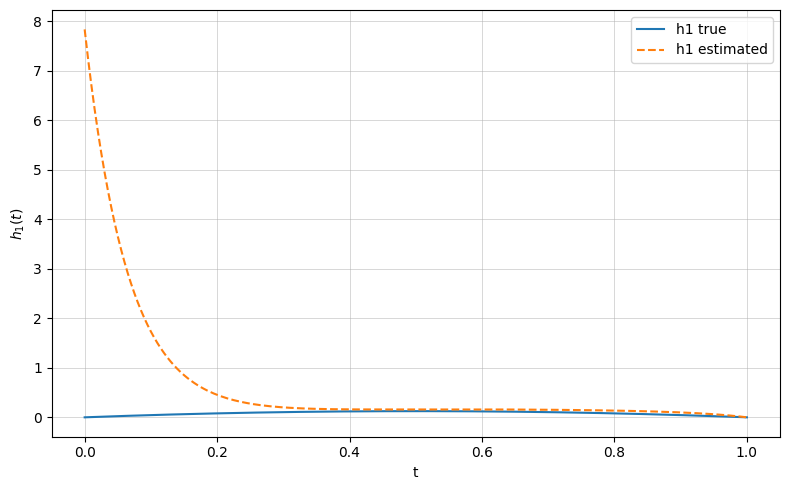

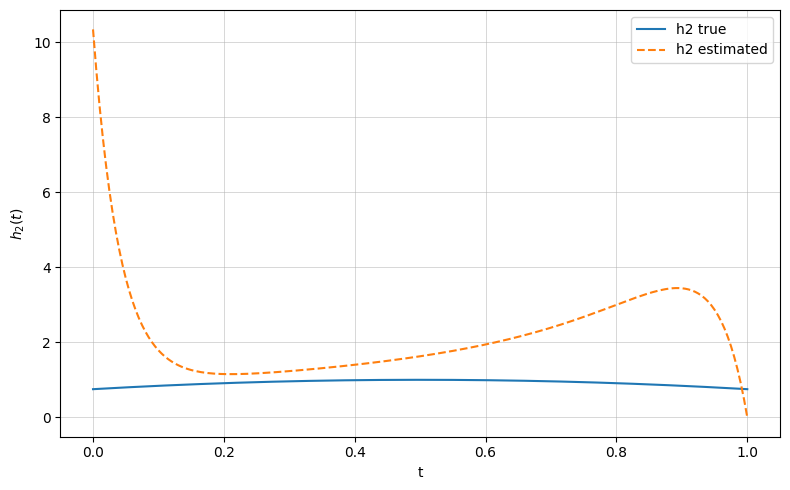

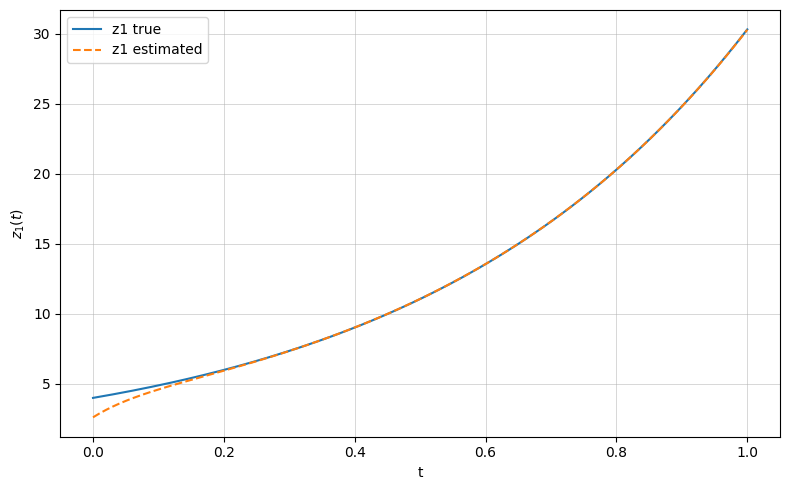

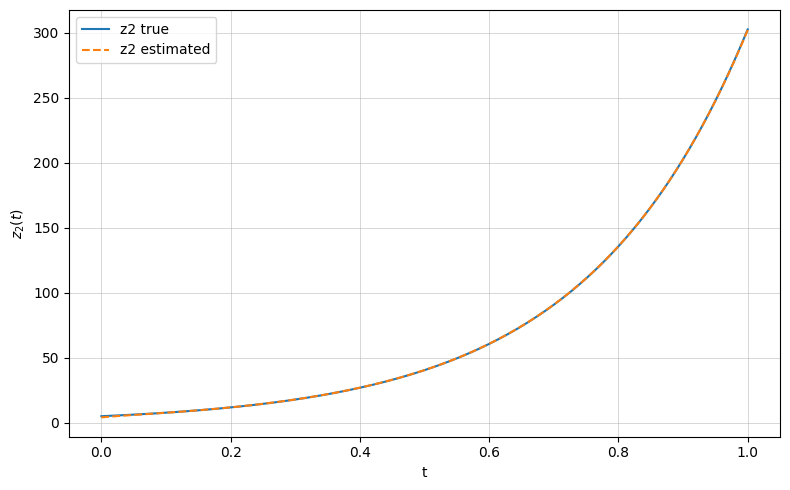

In [12]:
# Step 5: quick plots
import matplotlib.pyplot as plt
import os

outdir = "figs"
"""Create directory if it does not exist."""
os.makedirs(outdir, exist_ok=True)

plt.figure(figsize=(8, 5)); plt.plot(t, h_true[:, 0], label="h1 true"); plt.plot(t, h_est[:, 0], "--", label="h1 estimated"); plt.legend(); plt.xlabel("t"); plt.ylabel(r"$h_1(t)$"); plt.grid(alpha=0.7, linewidth=0.5); plt.tight_layout()
plt.savefig(os.path.join(outdir, "fig_n2_h1_true_vs_h1_estimated.png"), dpi=200)
plt.figure(figsize=(8, 5)); plt.plot(t, h_true[:, 1], label="h2 true"); plt.plot(t, h_est[:, 1], "--", label="h2 estimated"); plt.legend(); plt.xlabel("t"); plt.ylabel(r"$h_2(t)$"); plt.grid(alpha=0.7, linewidth=0.5); plt.tight_layout()
plt.savefig(os.path.join(outdir, "fig_n2_h2_true_vs_h2_estimated.png"), dpi=200)
plt.figure(figsize=(8, 5)); plt.plot(t, z_true[:, 0], label="z1 true"); plt.plot(t, z_est[:, 0], "--", label="z1 estimated"); plt.legend(); plt.xlabel("t"); plt.ylabel(r"$z_1(t)$"); plt.grid(alpha=0.7, linewidth=0.5); plt.tight_layout()
plt.savefig(os.path.join(outdir, "fig_n2_z1_true_vs_z1_estimated.png"), dpi=200)
plt.figure(figsize=(8, 5)); plt.plot(t, z_true[:, 1], label="z2 true"); plt.plot(t, z_est[:, 1], "--", label="z2 estimated"); plt.legend(); plt.xlabel("t"); plt.ylabel(r"$z_2(t)$"); plt.grid(alpha=0.7, linewidth=0.5); plt.tight_layout()
plt.savefig(os.path.join(outdir, "fig_n2_z2_true_vs_z2_estimated.png"), dpi=200)
plt.show()

In [8]:
# Metrics
z0_error = np.linalg.norm(z0_est - z0)
z_rmse = np.sqrt(np.mean((z_est - z_true)**2))
h_rmse = np.sqrt(np.mean((h_est - h_true)**2))
misfit = np.trapz(np.sum((C @ z_est.T - y_m.T)**2, axis=0), t)
energy = np.trapz(np.sum(h_est**2, axis=1), t)


print("===== Résultats =====")
print(f"z0 true = {z0}, z0 estimated = {z0_est}, error = {z0_error}")
print(f"RMSE(z) = {z_rmse:.3f}")
print(f"RMSE(h) = {h_rmse:.3f}")
print(f"Misfit = {misfit:.3f}")
print(f"Energy = {energy:.3f}")

===== Résultats =====
z0 true = [4. 5.], z0 estimated = [2.61258856 4.13579254], error = 1.6345534677167544
RMSE(z) = 0.213
RMSE(h) = 1.705
Misfit = 3.249
Energy = 8.619


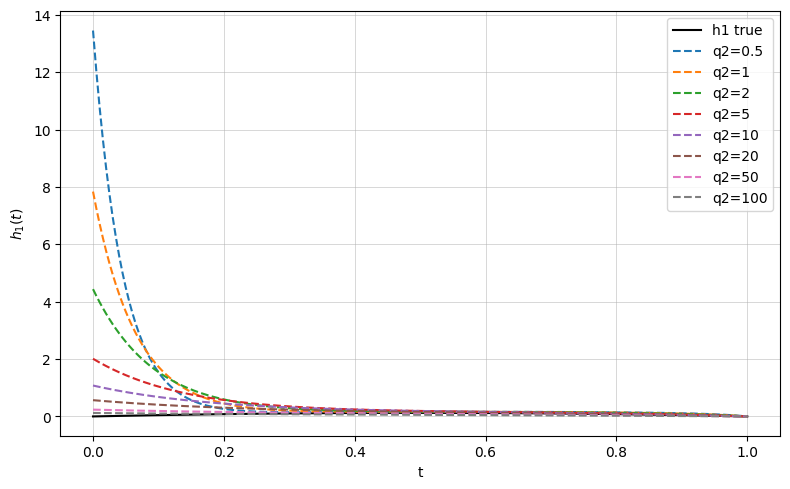

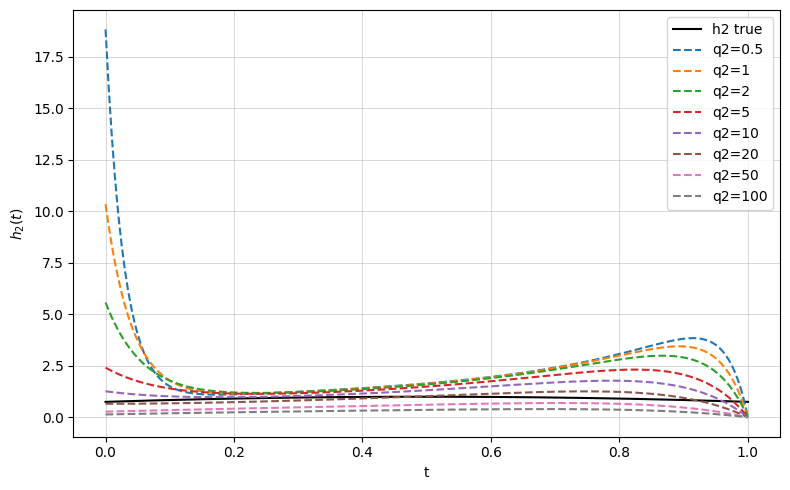

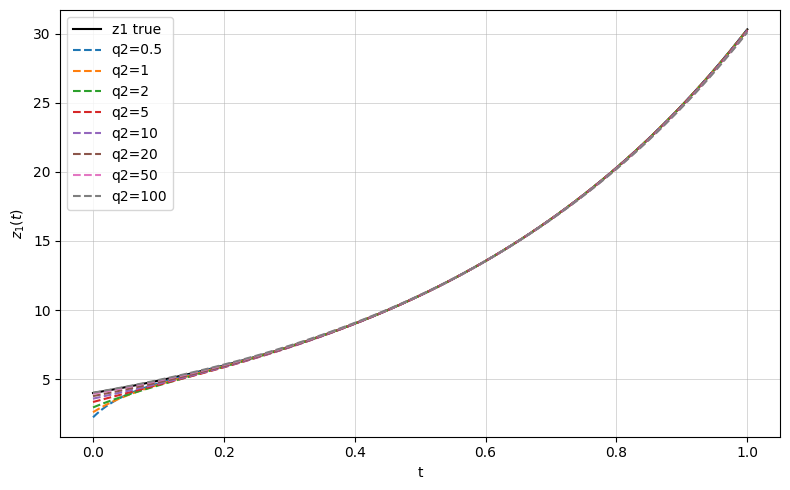

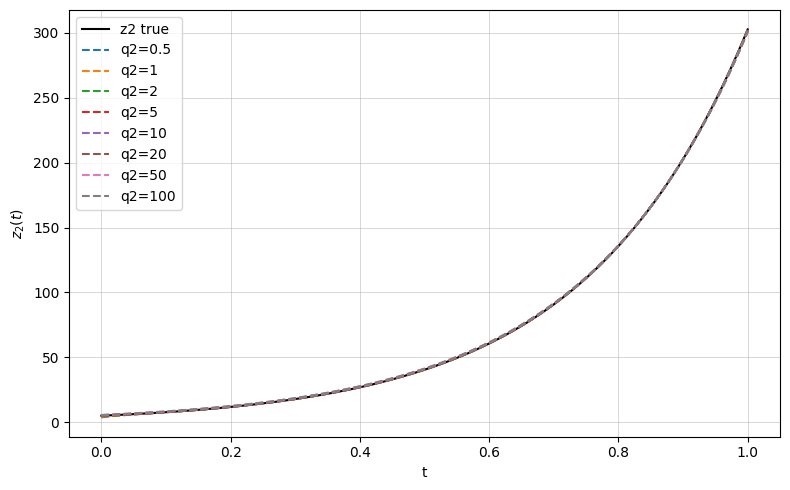

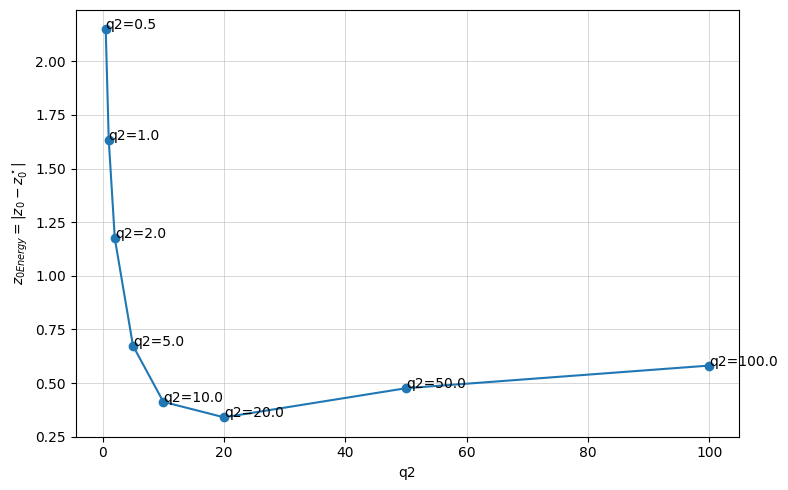

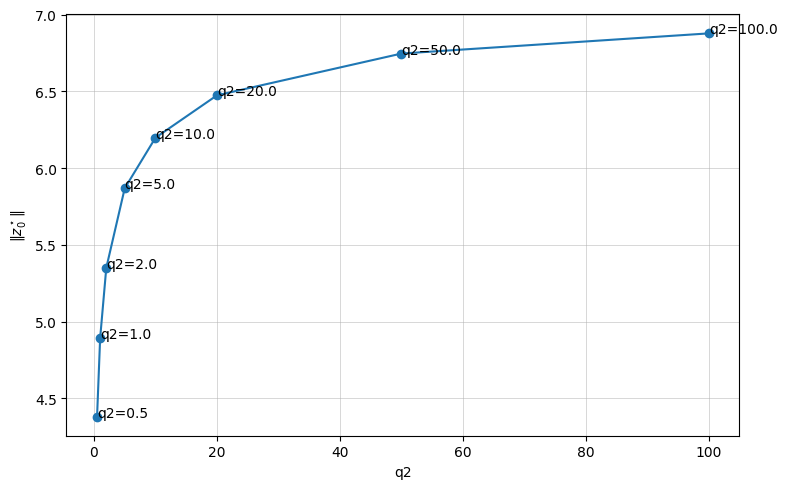

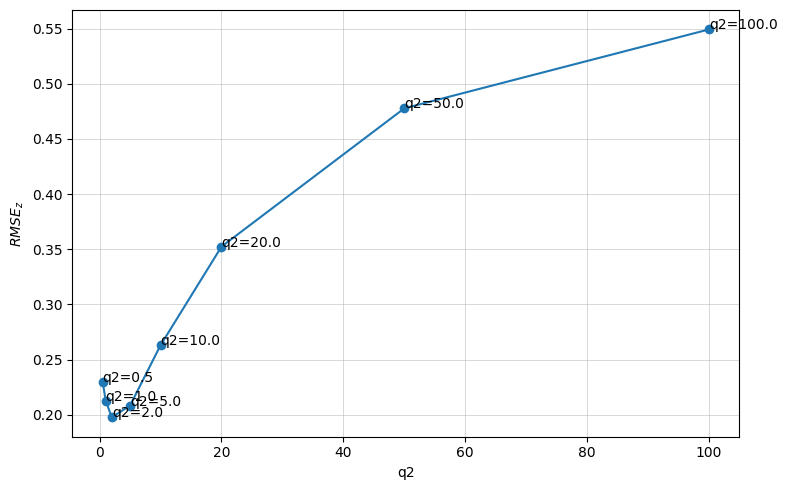

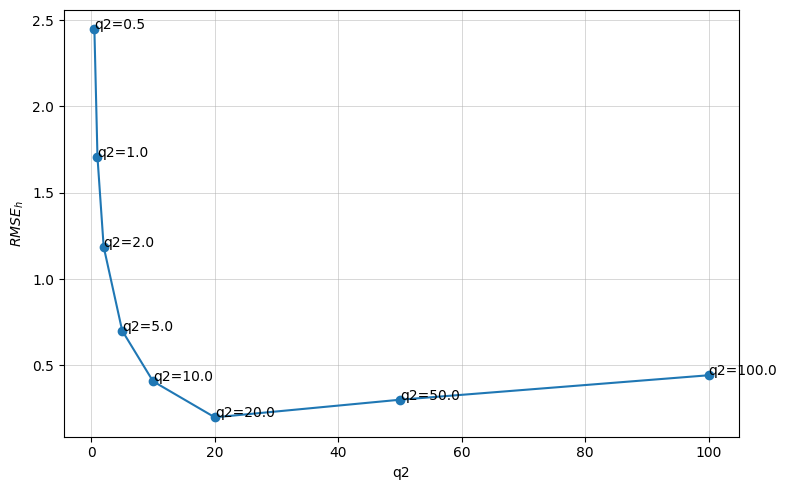

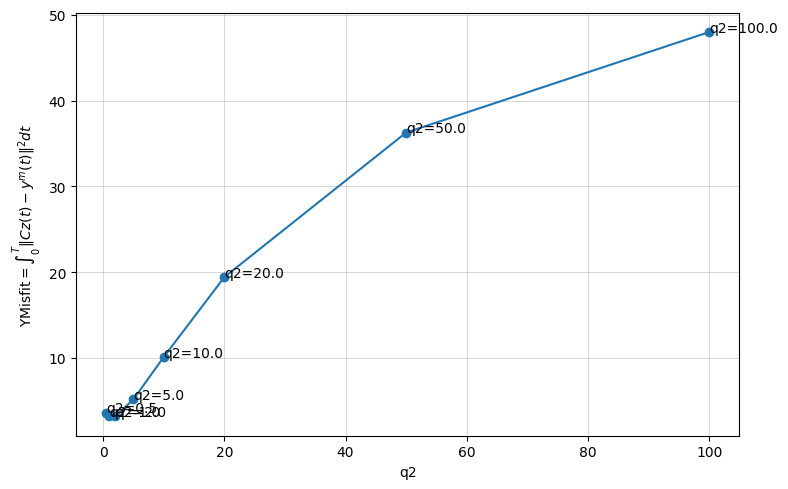

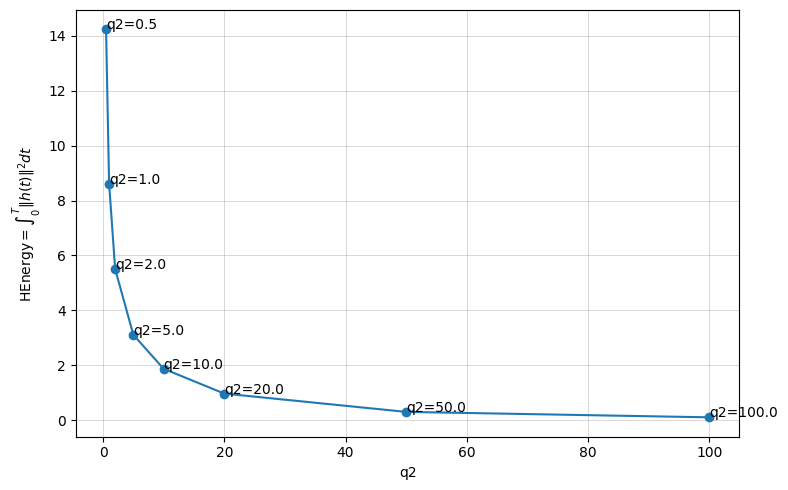

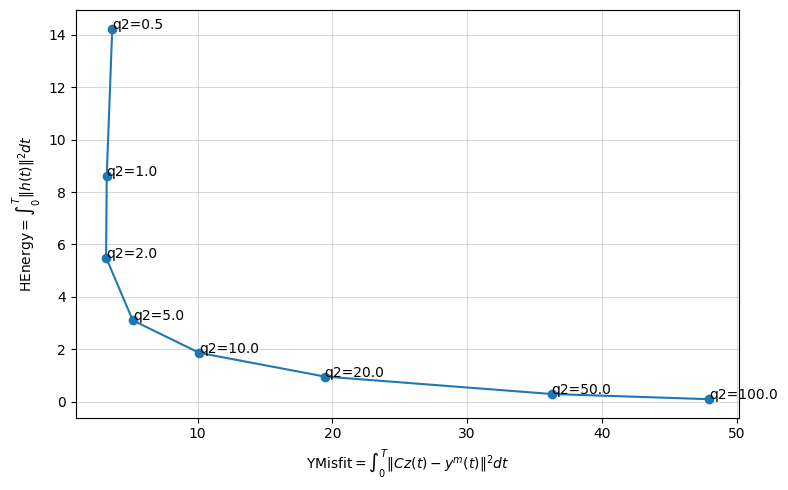

In [9]:
# Sensibility of q2: sweep q2, compute solutions & metrics
q1 = 1.0
#q2_list = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]
q2_list = [0.5, 1, 2, 5, 10, 20, 50, 100]
#q2_list = [0.25, 0.5, 1.0, 2.0, 5.0, 10.0]

curves_z1, curves_z2, curves_h1, curves_h2, metrics = [], [], [], [], []
for q2 in q2_list:
    z0_est, z_est, h_est = reconstruction(y_m, q1, q2)
    z0_error = np.linalg.norm(z0_est - z0)
    z0_energy = np.linalg.norm(z0_est)
    z_rmse = np.sqrt(np.mean((z_est - z_true)**2))
    h_rmse = np.sqrt(np.mean((h_est - h_true)**2))
    misfit = np.trapz(np.sum((C @ z_est.T - y_m.T)**2, axis=0), t)
    energy = np.trapz(np.sum(h_est**2, axis=1), t)
    
    curves_z1.append(z_est[:, 0]); curves_z2.append(z_est[:, 1])
    curves_h1.append(h_est[:, 0]); curves_h2.append(h_est[:, 1])
    metrics.append({
        "q2": q2,
        "z0_error": z0_error,
        "z0_energy": z0_energy,
        "z_rmse": z_rmse,
        "h_rmse": h_rmse,
        "misfit": misfit,
        "energy": energy,
    })
metrics = pd.DataFrame(metrics).sort_values("q2").reset_index(drop=True)

# Figures (overlays & curves)
plt.figure(figsize=(8, 5))
plt.plot(t, h_true[:, 0], "k-", label=f"h1 true")
for i, q2 in enumerate(q2_list):
    plt.plot(t, curves_h1[i], "--", label=f"q2={q2}")
plt.grid(alpha=0.7, linewidth=0.5)
plt.xlabel("t"); plt.ylabel(r"$h_1(t)$")
# plt.title("Sensibility in q2 of h1")
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(outdir, "fig_n2_h1_q2_sensibility.png"), dpi=200); #plt.close()

plt.figure(figsize=(8, 5))
plt.plot(t, h_true[:, 1], "k-", label=f"h2 true")
for i, q2 in enumerate(q2_list):
    plt.plot(t, curves_h2[i], "--", label=f"q2={q2}")
plt.grid(alpha=0.7, linewidth=0.5)
plt.xlabel("t"); plt.ylabel(r"$h_2(t)$")
# plt.title("Sensibility in q2 of h2")
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(outdir, "fig_n2_h2_q2_sensibility.png"), dpi=200); #plt.close()

plt.figure(figsize=(8, 5))
plt.plot(t, z_true[:, 0], "k-", label=f"z1 true")
for i, q2 in enumerate(q2_list):
    plt.plot(t, curves_z1[i], "--", label=f"q2={q2}")
plt.grid(alpha=0.7, linewidth=0.5)
plt.xlabel("t"); plt.ylabel(r"$z_1(t)$")
# plt.title("Sensibility in q2 of z1")
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(outdir, "fig_n2_z1_q2_sensibility.png"), dpi=200); #plt.close()

plt.figure(figsize=(8, 5))
plt.plot(t, z_true[:, 1], "k-", label=f"z2 true")
for i, q2 in enumerate(q2_list):
    plt.plot(t, curves_z2[i], "--", label=f"q2={q2}")
plt.grid(alpha=0.7, linewidth=0.5)
plt.xlabel("t"); plt.ylabel(r"$z_2(t)$")
# plt.title("Sensibility in q2 of z2")
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(outdir, "fig_n2_z2_q2_sensibility.png"), dpi=200); #plt.close()

plt.figure(figsize=(8, 5))
plt.plot(metrics["q2"], metrics["z0_error"], marker="o")
for i, row in metrics.iterrows():
    plt.annotate(f"q2={row['q2']}", (row["q2"], row["z0_error"]))
plt.grid(alpha=0.7, linewidth=0.5)
plt.xlabel("q2"); plt.ylabel(r"$z_{0Energy}=|z_0 - z_0^\star|$")
# plt.title(r"Error of $z_0$")
plt.tight_layout()
plt.savefig(os.path.join(outdir, "fig_n2_z0_error.png"), dpi=200); #plt.close()

plt.figure(figsize=(8, 5))
plt.plot(metrics["q2"], metrics["z0_energy"], marker="o")
for i, row in metrics.iterrows():
    plt.annotate(f"q2={row['q2']}", (row["q2"], row["z0_energy"]))
plt.grid(alpha=0.7, linewidth=0.5)
plt.xlabel("q2"); plt.ylabel(r"$\|z_0^\star\|$")
# plt.title(r"Energy of $z_0$")
plt.tight_layout()
plt.savefig(os.path.join(outdir, "fig_n2_z0_energy.png"), dpi=200); #plt.close()

plt.figure(figsize=(8, 5))
plt.plot(metrics["q2"], metrics["z_rmse"], marker="o")
for i, row in metrics.iterrows():
    plt.annotate(f"q2={row['q2']}", (row["q2"], row["z_rmse"]))
plt.grid(alpha=0.7, linewidth=0.5)
plt.xlabel("q2"); plt.ylabel(r"$RMSE_z$")
# plt.title(r"$RMSE_z$")
plt.tight_layout()
plt.savefig(os.path.join(outdir, "fig_n2_z_rmse.png"), dpi=200); #plt.close()

plt.figure(figsize=(8, 5))
plt.plot(metrics["q2"], metrics["h_rmse"], marker="o")
for i, row in metrics.iterrows():
    plt.annotate(f"q2={row['q2']}", (row["q2"], row["h_rmse"]))
plt.grid(alpha=0.7, linewidth=0.5)
plt.xlabel("q2"); plt.ylabel(r"$RMSE_h$")
# plt.title(r"$RMSE_h$")
plt.tight_layout()
plt.savefig(os.path.join(outdir, "fig_n2_h_rmse.png"), dpi=200); #plt.close()

plt.figure(figsize=(8, 5))
plt.plot(metrics["q2"], metrics["misfit"], marker="o")
for i, row in metrics.iterrows():
    plt.annotate(f"q2={row['q2']}", (row["q2"], row["misfit"]))
plt.grid(alpha=0.7, linewidth=0.5)
plt.xlabel("q2"); plt.ylabel(r"$\mathrm{YMisfit}=\int_0^T\|Cz(t)-y^m(t)\|^2 dt$")
# plt.title("Y Misfit as function of q2")
plt.tight_layout()
plt.savefig(os.path.join(outdir, "fig_n2_misfit_q2_sensibility.png"), dpi=200); #plt.close()

plt.figure(figsize=(8, 5))
plt.plot(metrics["q2"], metrics["energy"], marker="o")
for i, row in metrics.iterrows():
    plt.annotate(f"q2={row['q2']}", (row["q2"], row["energy"]))
plt.grid(alpha=0.7, linewidth=0.5)
plt.xlabel("q2"); plt.ylabel(r"$\mathrm{HEnergy}=\int_0^T \|h(t)\|^2 dt$")
# plt.title("H energy as function of q2")
plt.tight_layout()
plt.savefig(os.path.join(outdir, "fig_n2_energy_q2_sensibility.png"), dpi=200); #plt.close()

plt.figure(figsize=(8, 5))
plt.plot(metrics["misfit"], metrics["energy"], marker="o")
for i, row in metrics.iterrows():
    plt.annotate(f"q2={row['q2']}", (row["misfit"], row["energy"]))
plt.grid(alpha=0.7, linewidth=0.5)
plt.xlabel(r"$\mathrm{YMisfit}=\int_0^T\|Cz(t)-y^m(t)\|^2 dt$")
plt.ylabel(r"$\mathrm{HEnergy}=\int_0^T \|h(t)\|^2 dt$")
# plt.title("Compromis YMisfit/HEnergy")
plt.tight_layout()
plt.savefig(os.path.join(outdir, "fig_n2_misfit_energy_q2_sensibility.png"), dpi=200); #plt.close()

plt.show()

In [10]:
metrics

,q2,z0_error,z0_energy,z_rmse,h_rmse,misfit,energy
0,0.5,2.148859,4.381370,0.230046,2.445812,3.656920,14.237373
1,1.0,1.634553,4.891871,0.212884,1.705170,3.248564,8.618521
2,2.0,1.174468,5.350100,0.197636,1.188024,3.198064,5.503494
3,5.0,0.674053,5.868383,0.208316,0.701516,5.180257,3.106177
4,10.0,0.412576,6.197495,0.262982,0.408316,10.112533,1.867303
5,20.0,0.340364,6.473648,0.352380,0.199772,19.422211,0.963806
6,50.0,0.476001,6.745742,0.477813,0.301730,36.270146,0.296856
7,100.0,0.581659,6.877191,0.549374,0.443388,47.978481,0.098896
